# Exercise class 7: Stochastic Gradient Descent

Luca Calatroni (calatroni@i3s.unice.fr)

For a least-square regression problem with ridge regression, the objective of this lab session is to implement:

- SGD algorith with constant stepsizes
- SGD algorithm with shrinking stepsizes
- SGD with late averaging
- SGD with momentum

and compare your solution with the one found by deterministic solvers.

This exercise class is largely inspired by the one given by Robert Gower at the Cornell course on optimization for machine learning given in 2020, please check: https://gowerrobert.github.io/.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
from practice07_SGD import *
from scipy.linalg import norm
from scipy.optimize import check_grad, fmin_l_bfgs_b

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

<a id='loss'></a>

## 1. Loss functions, gradients and Lipschitz constants

Given a matrix $\mathbf{X} = [x_1, \ldots, x_n] \in\mathbb{R}^{d\times n}$, $\lambda> 0$ we want to solve the linear regression problem

$$
\text{find }\quad w\quad\text{ s.t. }\quad b=\mathbf{X}w + n,
$$

$\left\{ b_i, x_{i,1},\ldots,x_{i,n}\right\}_{i=1,\ldots,d}$ is a dataset of $n$ statistical units. Linear regression model takes the form:

$$
b_i = x_i^T w + n_i
$$

where for $i=1,\ldots,n$ $x_i$ is the vector with components $x_i = (x_{j,i})_{j=1,\ldots,d}$.

Standard approach (inverse problem type): least-square regression with ridge regularization:

$$
\min_{w\in\mathbb{R}^d}~ \left\{ f(w):=\frac{1}{2n} \sum_{i=1}^n | x_i^\top w- b_i |^2 + \frac \lambda 2 \|w\|_2^2 \right\}
$$

Note that $f$ is smooth and convex. We write it as a a minimization problem of the form

$$
\frac 1n \sum_{i=1}^n f_i(w)
$$

where

$$
f_i(w) = \frac 12 | x_i^\top w- b_i |^2 + \frac \lambda 2 \|w\|_2^2.
$$

The gradient reads:

$$
\nabla f_i(w) = (x_i^\top w - y_i) x_i + \lambda w
$$

Denote by $L$ the Lipschitz constant of $\nabla f$.
One can check that:

$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{n} + \lambda.
$$

Recall that for classical (non-stochastic) gradient descent algorithm, the upper bound on the step-size is $1 / L$.

Introduce a solver class first.


In [3]:
# LinReg

# 2. Dataset generation

We generate datasets. First, let us define a function.


In [4]:
# simu_linreg

In [5]:
d = 50
n = 1000
idx = np.arange(d)

# Ground truth coefficients of the model
w_model_truth = (-1) ** idx * np.exp(-idx / 10.0)

X, y = simu_linreg(w_model_truth, n, std=1.0, corr=0.25)
X.shape

(1000, 50)

In [6]:
lbda = 1.0 / n ** (0.5)
model = LinReg(X, y, lbda)  # forward problem


<StemContainer object of 3 artists>

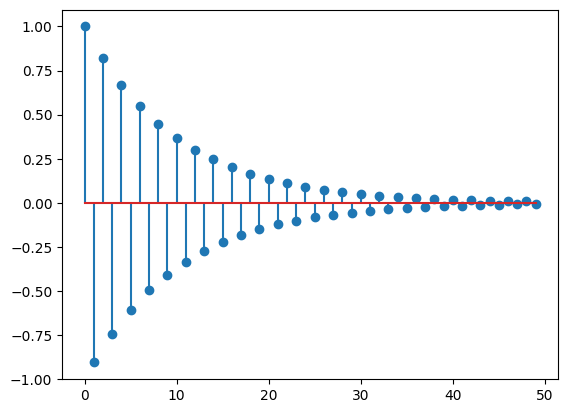

In [7]:
# plot of ground truth w
plt.stem(w_model_truth)


In [8]:

model_lin = LinReg(X, y, lbda)
# Check that the computation of the gradient and of the
# loss numerically match in correspondence of a random point
check_grad(model_lin.f, model_lin.grad, np.random.randn(d))


5.5302065119513845e-06

2.656912286532642e-06


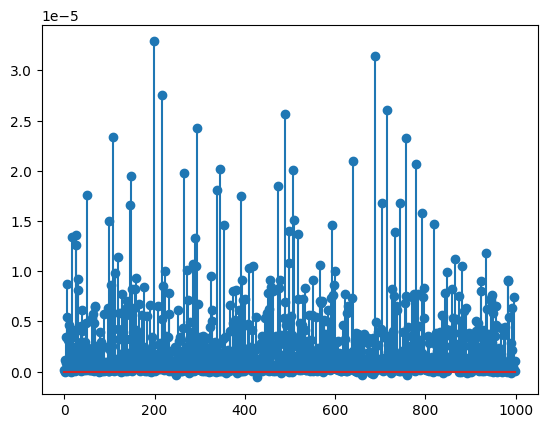

In [9]:
# Check that the gradient grad_i and the numerical gradient of f_i agree
grad_error = []
for i in range(n):
  ind = np.random.choice(n, 1)
  w = np.random.randn(d)
  vec = np.random.randn(d)
  eps = pow(10.0, -7.0)
  model.f_i(ind[0], w)
  grad_error.append(
    (model.f_i(ind[0], w + eps * vec) - model.f_i(ind[0], w)) / eps
    - np.dot(model.grad_i(ind[0], w), vec)
  )
plt.stem(grad_error)
print(np.mean(grad_error))


### Find a highly accurate solution using LBFGS method


LBFGS is a Newton-type solver for the problem. It can rarely be applied in practical situations as it requires the computation of full gradients (if not Hessian approximations). We use this to find a solution to compare to.


In [10]:
w_init = np.zeros(d)
w_min, obj_min, _ = fmin_l_bfgs_b(
  model.f, w_init, model.grad, args=(), pgtol=1e-30, factr=1e-30
)

print(obj_min)
print(norm(model.grad(w_min)))


0.5490892188811172
4.562028973565455e-09


## 3. Plain SGD


**for** $k=1,\ldots,\texttt{maxiter}$

$\qquad$ Pick $i$ uniformly at random in $\{1, \ldots, n\}$

$\qquad \displaystyle
w_{k+1} \gets w_k - \tau_k \nabla f_i(w_k)
$

**till convergence**

**Complete the code** writing the SGD iteration. The inputs are

- n_iter: The number of iterations $\texttt{maxiter}$ of the SGD algorithm
- indices: an np.array of indices of length n_iter. The indices[k] is the random index of the that will be used for the computation of the kth iteration.
- steps: an np.array of positive floats of length n_iter. The steps[k] is the stepsize $\tau_k$ used on the kth iteration. Either fixed or decreasing stepsizes are used $\tau_k = \frac{C}{k+1}$, where $C$ is tuned.

- averaging_on: is a boolean which indicates if the output should be the average of the iterates.

The outputs are:

- x*output: The final x vector found by the algorithm or the average $ \bar{w} = \frac{1}{\texttt{maxiter}-k}\sum*{i=k}^{\texttt{maxiter}} w_k$ if averaging is on
- objectives: A ndarray containing the sequence function values calculated during the iterations of the algorithm
- errors: If w_min is not empty, errors is a ndarray containing the sequence of errors || w - w_min || of the algorithm. For us w_min is the solution computed by LBFGS. Otherwise errors should be empty.


In [11]:
w_init

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
# sgd

In [13]:
##Setup number of iterations/passes
datapasses = 20  # number of sweeps through all the data. This means that there will datapasses*n stochastic gradient updates
n_iter = int(datapasses * n)


### SGD with constant step

Implement SGD withconstant stepsize $\tau_k \equiv \tau = 1/(2L_{\max})$ for all $k=1,\ldots,\texttt{maxiter}$.


In [14]:
# generate beforehand the vector of random components (with replacement)
indices = np.random.choice(n, n_iter + 1, replace=True)
# np.size(indices)

Lmax = model.L_max_constant()
steps = np.ones(n_iter + 1) / (2 * Lmax)

w0 = np.zeros(d)
# averaging_on=False, momentum =0, verbose=True, start_late_averaging = 0
w_sgdcr, obj_sgdcr, err_sgdcr = sgd(
  w0=w0,
  model=model,
  indices=indices,
  steps=steps,
  w_min=w_min,
  n_samples=n,
  n_features=d,
  n_iter=n_iter,
  verbose=True,
)


Lauching SGD solver...
   it    |   obj    |   err   
       0 | 2.17e+00 | 1.00e+00
    1000 | 6.20e-01 | 1.63e-01
    2000 | 6.30e-01 | 1.76e-01
    3000 | 6.12e-01 | 1.60e-01
    4000 | 6.37e-01 | 1.89e-01
    5000 | 6.77e-01 | 2.06e-01
    6000 | 6.20e-01 | 1.74e-01
    7000 | 6.40e-01 | 1.88e-01
    8000 | 6.52e-01 | 1.87e-01
    9000 | 6.26e-01 | 1.65e-01
   10000 | 6.48e-01 | 1.90e-01
   11000 | 6.38e-01 | 1.78e-01
   12000 | 6.32e-01 | 1.74e-01
   13000 | 6.24e-01 | 1.75e-01
   14000 | 6.44e-01 | 1.72e-01
   15000 | 6.13e-01 | 1.50e-01
   16000 | 6.05e-01 | 1.56e-01
   17000 | 6.27e-01 | 1.67e-01
   18000 | 6.41e-01 | 1.83e-01
   19000 | 6.11e-01 | 1.50e-01


### SGD with decaying step-sizes

Run SGD with the decreasing choice of $\tau_k = \frac{C}{\sqrt{k+1}}$, where $C=\frac{2}{L_{max}}$.


In [15]:
# Write here the vector steps of decreasing step-sizes
steps = 2 / (Lmax * (np.sqrt(np.arange(1, n_iter + 2))))
w_sgdsr, obj_sgdsr, err_sgdsr = sgd(
  w0=w0,
  model=model,
  indices=indices,
  steps=steps,
  w_min=w_min,
  n_samples=n,
  n_features=d,
  n_iter=n_iter,
)


Lauching SGD solver...
   it    |   obj    |   err   
       0 | 2.17e+00 | 1.00e+00
    1000 | 8.15e-01 | 4.06e-01
    2000 | 6.79e-01 | 2.85e-01
    3000 | 6.20e-01 | 2.11e-01
    4000 | 5.96e-01 | 1.71e-01
    5000 | 5.82e-01 | 1.44e-01
    6000 | 5.74e-01 | 1.24e-01
    7000 | 5.68e-01 | 1.07e-01
    8000 | 5.65e-01 | 9.38e-02
    9000 | 5.59e-01 | 7.98e-02
   10000 | 5.58e-01 | 7.45e-02
   11000 | 5.57e-01 | 6.56e-02
   12000 | 5.56e-01 | 6.06e-02
   13000 | 5.55e-01 | 5.72e-02
   14000 | 5.55e-01 | 5.67e-02
   15000 | 5.54e-01 | 5.07e-02
   16000 | 5.53e-01 | 4.56e-02
   17000 | 5.53e-01 | 4.37e-02
   18000 | 5.53e-01 | 4.21e-02
   19000 | 5.52e-01 | 3.91e-02


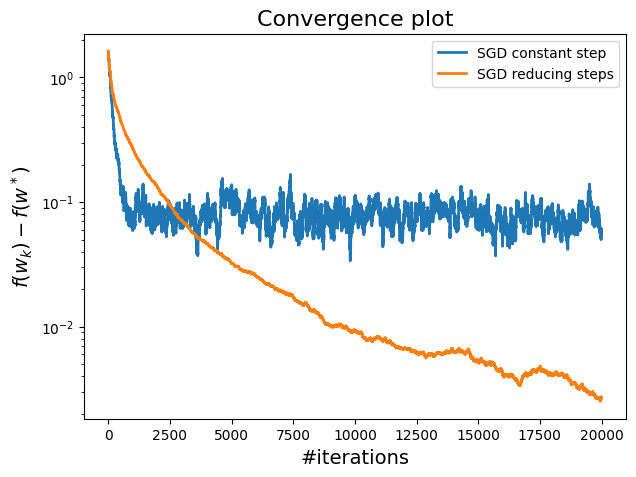

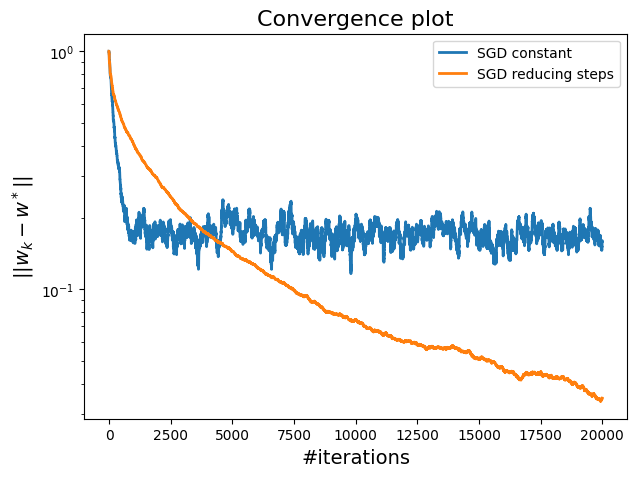

In [16]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD constant step", lw=2)
plt.semilogy(obj_sgdsr - obj_min, label="SGD reducing steps", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$f(w_k) - f(w^*)$", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr, label="SGD constant", lw=2)
plt.semilogy(err_sgdsr, label="SGD reducing steps", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$|| w_k - w^* ||$", fontsize=14)
plt.legend()


### SGD with switch to shrinking stepsizes


In [17]:
mu = model.mu_constant()
Kappa = Lmax / mu
kstar = 4 * int(np.ceil(Kappa))


Test SGD with the following switching stepsizes given in the lecture

$$
\tau_k= 
\begin{cases}
\displaystyle \tfrac{1}{2L_{\max}} & \text{for}\quad k \leq 4\lceil\mathcal{K} \rceil \\[0.3cm]
\displaystyle \tfrac{2k+1}{(k+1)^2 \mu} &  \text{for}\quad k > 4\lceil\mathcal{K} \rceil.
\end{cases}
$$


In [18]:
steps_switch = np.zeros(n_iter + 1)

# Write here the vector of switching step-sizes steps_switch
# using for + if/else loop

steps_switch = np.array(
  [
    2 / Lmax if k < kstar else (2 * k + 1) / (((k + 1) ** 2) * mu)
    for k in range(n_iter + 1)
  ]
)
# for k in range(n_iter):
#


In [19]:
indices = np.random.choice(n, n_iter + 1, replace=True)
np.size(indices)
# w_sgdss, obj_sgdss, err_sgdss = sgd(w0, model, indices, steps_switch, w_min, n_iter)
w_sgdss, obj_sgdss, err_sgdss = sgd(
  w0=w0,
  model=model,
  indices=indices,
  steps=steps_switch,
  w_min=w_min,
  n_samples=n,
  n_features=d,
  n_iter=n_iter,
)


Lauching SGD solver...
   it    |   obj    |   err   
       0 | 2.20e+00 | 9.98e-01
    1000 | 7.26e-01 | 2.93e-01
    2000 | 5.87e-01 | 1.25e-01
    3000 | 5.65e-01 | 8.17e-02
    4000 | 5.65e-01 | 8.05e-02
    5000 | 5.61e-01 | 6.54e-02
    6000 | 5.57e-01 | 5.49e-02
    7000 | 5.56e-01 | 4.81e-02
    8000 | 5.55e-01 | 4.31e-02
    9000 | 5.54e-01 | 4.25e-02
   10000 | 5.53e-01 | 3.99e-02
   11000 | 5.52e-01 | 3.94e-02
   12000 | 5.54e-01 | 4.34e-02
   13000 | 5.53e-01 | 4.15e-02
   14000 | 5.54e-01 | 4.18e-02
   15000 | 5.53e-01 | 3.74e-02
   16000 | 5.53e-01 | 3.87e-02
   17000 | 5.53e-01 | 3.74e-02
   18000 | 5.52e-01 | 3.47e-02
   19000 | 5.52e-01 | 3.14e-02


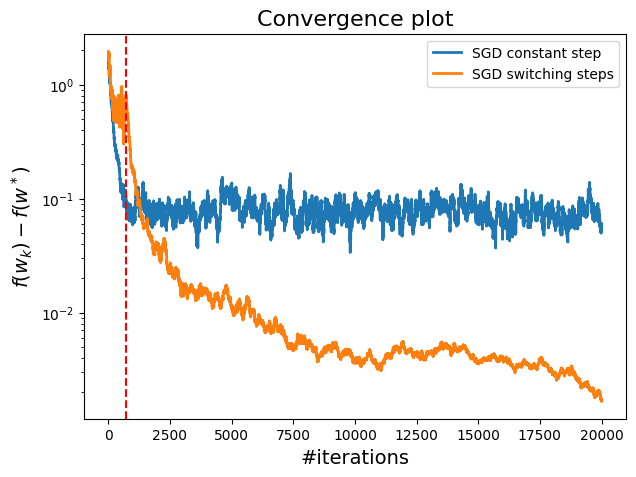

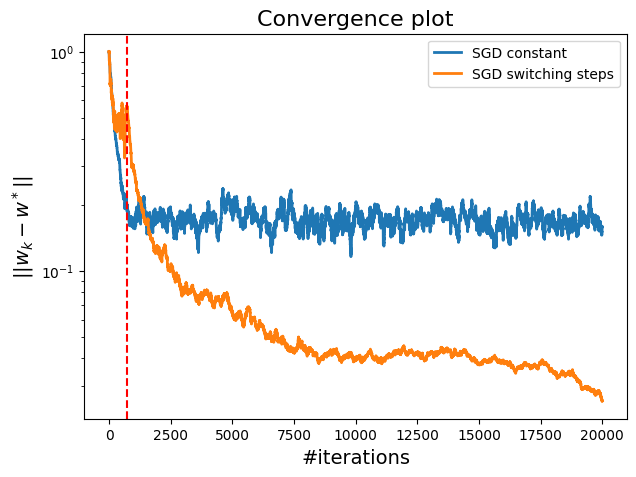

In [20]:
# Plotting to compare with constant stepsize
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD constant step", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switching steps", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$f(w_k) - f(w^*)$", fontsize=14)
plt.legend()
plt.axvline(x=kstar, color="red", linestyle="dashed")
# plt.savefig('images/sgd_switch_err.png', bbox_inches='tight')

# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr, label="SGD constant", lw=2)
plt.semilogy(err_sgdss, label="SGD switching steps", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$|| w_k - w^* ||$", fontsize=14)
plt.legend()

plt.axvline(x=kstar, color="red", linestyle="dashed")
# plt.savefig('images/sgd_switch_dist.png', bbox_inches='tight')


## 5. Compare with averaging step

Let us fix for simplicity a starting point for half of $\texttt{maxiter}$.


In [21]:
indices = np.random.choice(n, n_iter + 1, replace=True)

start_late_averaging1 = n_iter / 2
averaging_on = True
# w_sgdar, obj_sgdar, err_sgdar = sgd(
#   w0,
#   model,
#   indices,
#   steps_switch,
#   w_min,
#   n_iter,
#   averaging_on,
#   0.0,
#   True,
#   start_late_averaging1,
# )  # (datapasses-5)*n
w_sgdar, obj_sgdar, err_sgdar = sgd(
  w0=w0,
  model=model,
  indices=indices,
  steps=steps_switch,
  w_min=w_min,
  n_samples=n,
  n_features=d,
  n_iter=n_iter,
  averaging_on=averaging_on,
  momentum=0.0,
  verbose=True,
  start_late_averaging=start_late_averaging1,
)


Lauching SGD solver...
   it    |   obj    |   err   
       0 | 2.20e+00 | 9.98e-01
    1000 | 6.48e-01 | 2.15e-01
    2000 | 5.67e-01 | 9.24e-02
    3000 | 5.62e-01 | 7.22e-02
    4000 | 5.62e-01 | 7.43e-02
    5000 | 5.58e-01 | 5.93e-02
    6000 | 5.56e-01 | 5.08e-02
    7000 | 5.55e-01 | 4.74e-02
    8000 | 5.56e-01 | 4.76e-02
    9000 | 5.53e-01 | 4.16e-02
   10000 | 5.54e-01 | 4.42e-02
   11000 | 5.54e-01 | 4.43e-02
   12000 | 5.54e-01 | 4.33e-02
   13000 | 5.53e-01 | 4.10e-02
   14000 | 5.53e-01 | 4.00e-02
   15000 | 5.53e-01 | 3.84e-02
   16000 | 5.52e-01 | 3.66e-02
   17000 | 5.52e-01 | 3.50e-02
   18000 | 5.52e-01 | 3.29e-02
   19000 | 5.51e-01 | 3.06e-02


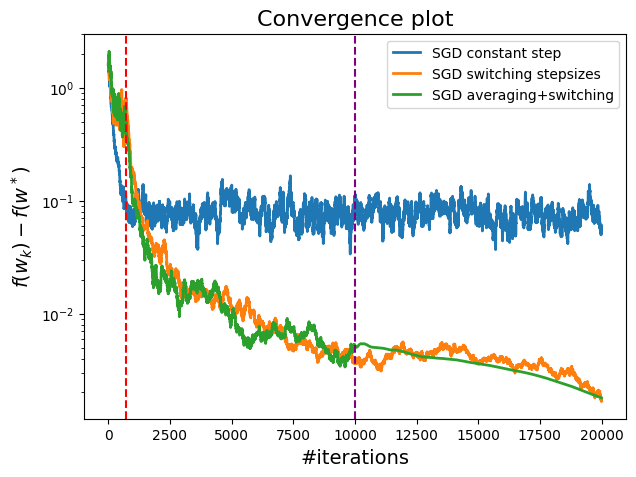

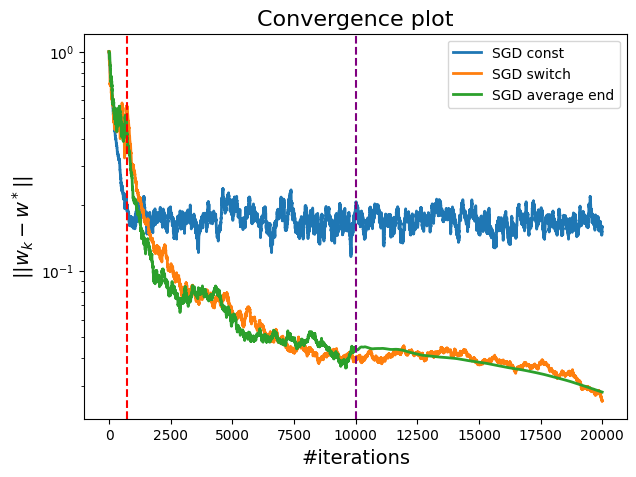

In [22]:
# Plotting to compare constant stepsize, switchting, switching + averaging
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD constant step", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switching stepsizes", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD averaging+switching", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$f(w_k) - f(w^*)$", fontsize=14)
plt.legend()
plt.axvline(x=kstar, color="red", linestyle="dashed")
plt.axvline(x=start_late_averaging1, color="purple", linestyle="dashed")
# plt.savefig('images/sgd_switch_average_err.png', bbox_inches='tight')
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdcr, label="SGD const", lw=2)
plt.semilogy(err_sgdss, label="SGD switch", lw=2)
plt.semilogy(err_sgdar, label="SGD average end", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$|| w_k - w^* ||$", fontsize=14)
plt.legend()
plt.axvline(x=kstar, color="red", linestyle="dashed")
plt.axvline(x=start_late_averaging1, color="purple", linestyle="dashed")
# plt.savefig('images/sgd_switch_average_dist.png', bbox_inches='tight')


## Compare with SGD with momentum (SGDm)

Let us introduce momentum in the main routine and add a flag momentum$\in[0,1]$ for calling it. Keep switching stepsizes and remove averaging (try to play with such parameters as you like).


In [23]:
indices = np.random.choice(n, n_iter + 1, replace=True)
averaging_on = True
start_late_averaging = 0
momentum = 0.3
# w_sgdm, obj_sgdm, err_sgdm = sgd(
#   w0,
#   model,
#   indices,
#   steps_switch,
#   w_min,
#   n_iter,
#   averaging_on,
#   momentum,
#   True,
#   start_late_averaging,
# )  # (datapasses-5)*n

w_sgdm, obj_sgdm, err_sgdm = sgd(
  w0=w0,
  model=model,
  indices=indices,
  steps=steps_switch,
  w_min=w_min,
  n_samples=n,
  n_features=d,
  n_iter=n_iter,
  averaging_on=averaging_on,
  momentum=momentum,
  verbose=True,
  start_late_averaging=start_late_averaging,
)


Lauching SGD solver...
   it    |   obj    |   err   
       0 | 2.19e+00 | 1.00e+00
    1000 | 6.74e-01 | 2.42e-01
    2000 | 5.89e-01 | 1.40e-01
    3000 | 5.69e-01 | 9.72e-02
    4000 | 5.62e-01 | 7.73e-02
    5000 | 5.58e-01 | 6.48e-02
    6000 | 5.56e-01 | 5.71e-02
    7000 | 5.55e-01 | 5.25e-02
    8000 | 5.54e-01 | 4.84e-02
    9000 | 5.53e-01 | 4.49e-02
   10000 | 5.53e-01 | 4.19e-02
   11000 | 5.53e-01 | 3.97e-02
   12000 | 5.52e-01 | 3.79e-02
   13000 | 5.52e-01 | 3.59e-02
   14000 | 5.52e-01 | 3.44e-02
   15000 | 5.52e-01 | 3.34e-02
   16000 | 5.51e-01 | 3.17e-02
   17000 | 5.51e-01 | 3.01e-02
   18000 | 5.51e-01 | 2.90e-02
   19000 | 5.51e-01 | 2.78e-02


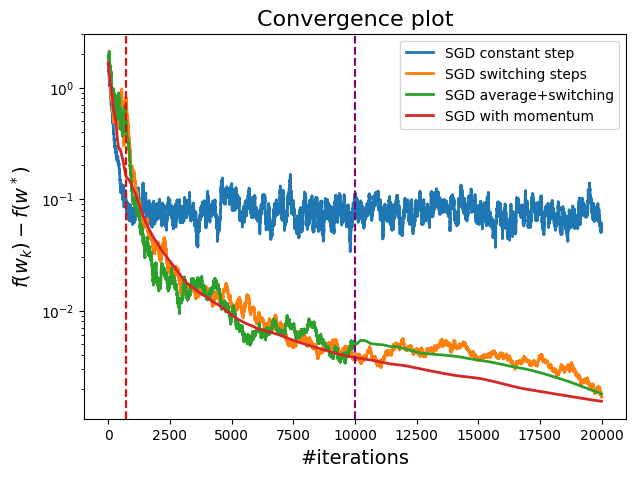

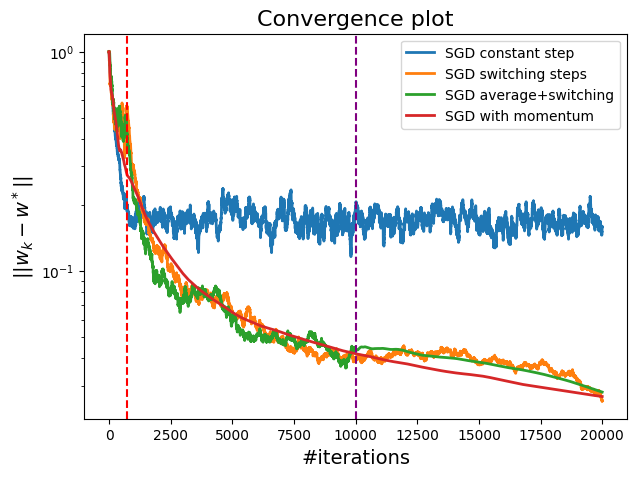

In [24]:
# Plotting to compare constant stepsize, switchting, switching + averaging
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD constant step", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switching steps", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD average+switching", lw=2)
plt.semilogy(obj_sgdm - obj_min, label="SGD with momentum", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$f(w_k) - f(w^*)$", fontsize=14)
plt.legend()
plt.axvline(x=kstar, color="red", linestyle="dashed")
plt.axvline(x=start_late_averaging1, color="purple", linestyle="dashed")
# plt.savefig('images/sgd_switch_average_err.png', bbox_inches='tight')
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdcr, label="SGD constant step", lw=2)
plt.semilogy(err_sgdss, label="SGD switching steps", lw=2)
plt.semilogy(err_sgdar, label="SGD average+switching", lw=2)
plt.semilogy(err_sgdm, label="SGD with momentum", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$|| w_k - w^* ||$", fontsize=14)
plt.legend()
plt.axvline(x=kstar, color="red", linestyle="dashed")
plt.axvline(x=start_late_averaging1, color="purple", linestyle="dashed")
# plt.savefig('images/sgd_switch_average_dist.png', bbox_inches='tight')
